In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate as inter
import scipy.stats
import emcee
from matplotlib import cm

%matplotlib inline

In [2]:
def likelihood(x, y, redshift, density, error_lower, error_upper):
    #compute the spline given x,y
    sset=inter.UnivariateSpline(x, y, k=2)

    #evaluate the spline at the redshift datapoints
    model_density= sset(redshift)

    #the likelihood
    L=1.
    for i in range(len(redshift)):
        #the likelihood of each model datapoint will be given by the corresponding datapoint pdf
        if(model_density[i]<density[i]):
            auxL= gaussian(model_density[i], density[i], error_lower[i])
        else:
            auxL= gaussian(model_density[i], density[i], error_upper[i])
        #product of the likelihoods
        L=L*auxL

    return L

In [3]:
def logposterior(y, x, redshift, density, error_lower, error_upper, sigma):
    #the likelihood
    L=likelihood(x, y, redshift, density, error_lower, error_upper)

    #the gaussian prior
    auxprior=np.ones(len(y))
    for i in range(len(y)-2):
        auxprior[i+1]=gaussian(y[i+1], y[i], sigma)*gaussian(y[i+1], y[i+2], sigma) #correlation with immediate neighbors
    prior=np.prod(auxprior)*gaussian(y[0], y[1], sigma)*gaussian(y[-1], y[-2], sigma) #include first and last points

    return np.log(L*prior)

In [16]:
#emcee execution
def montecarlo(x_knots, sigma):

    #import catalog
    aux= np.genfromtxt('mock.dat')
    redshift, density, error_lower, error_upper= aux[:,0], aux[:,1], aux[:,2], aux[:,3]

    #plot catalog
    plt.plot(redshift, density, 'o', color='blue')
    plt.errorbar(redshift, density, yerr=[error_lower, error_upper], color='blue', fmt=None, linewidth=2)
    plt.xlim(0,7)
    plt.savefig('plot_catalog'+str(sigma)+'.png')
    plt.show()#block=False)
    print('plotted catalog!')

    #lets try the posterior!
    #almost perfect solution
    y_knots= np.array([2., 2.5, 2.]); print 10**logposterior(y_knots, x_knots, redshift, density, error_lower, error_upper, sigma)
    #reasonable solution
    y_knots= np.array([1.5, 2.5, 1.5]); print 10**logposterior(y_knots, x_knots, redshift, density, error_lower, error_upper, sigma)
    #bad solution
    y_knots= np.array([2., 1., 2.]); print 10**logposterior(y_knots, x_knots, redshift, density, error_lower, error_upper, sigma)


    #lets run emcee to get the posterior pdf
    N=500; nwalkers=100; ndim=len(x_knots); Nconverge=100
    p0=np.zeros((nwalkers, ndim))
    for i in range(nwalkers):
        p0[i,0]=np.random.uniform(0., 5.)
        p0[i,1]=np.random.uniform(0., 5.)
        p0[i,2]=np.random.uniform(0., 5.)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[x_knots, redshift, density, error_lower, error_upper, sigma])
    pos, prob, state= sampler.run_mcmc(p0, Nconverge)
    sampler.reset()

    pos, prob, state= sampler.run_mcmc(pos, N)
    return sampler.flatchain

In [5]:
#just a gaussian
def gaussian(x, a1, a2):
    z= (x-a1)/a2
    return np.exp((-z**2)/2)/(2*math.pi*a2**2)**.5

In [6]:
#just a function to obtain contours
def plotting(background_muv, background_beta, ranges, nbins, smooth=False):

    indices=np.where((np.isfinite(background_muv)==True) & (np.isfinite(background_beta)==True))
    background_muv=background_muv[indices]
    background_beta=background_beta[indices]

    if(smooth==True):
          auxL, Amuv, thetabeta =np.histogram2d(background_muv, background_beta, bins=nbins, range=ranges)
          X, Y = np.meshgrid(Amuv, thetabeta)
          positions = np.vstack([X.ravel(), Y.ravel()])
          values = np.vstack([background_muv, background_beta])
          kernel = scipy.stats.gaussian_kde(values)
          auxL = np.reshape(kernel(positions).T, X.shape)
          auxL=auxL.T/np.nansum(auxL)

    else:
          auxL, A1, theta1 =np.histogram2d(background_muv, background_beta, bins=nbins, range=ranges)
          auxL=auxL/np.nansum(auxL)
          aux=np.zeros((len(auxL[:,0]), len(auxL[0,:])))
          Amuv=np.zeros(np.shape(auxL)[0]); thetabeta=np.zeros(np.shape(auxL)[1])

          for i in range(len(Amuv)):
              Amuv[i]=A1[i]+.5*(A1[i+1]-A1[i])
          for i in range(len(thetabeta)):
              thetabeta[i]=theta1[i]+.5*(theta1[i+1]-theta1[i])


    index=np.where(auxL==np.max(auxL))

    aux=np.zeros((len(auxL[:,0]), len(auxL[0,:])))
    for i in range(len(auxL[:,0])):
        for j in range(len(auxL[0,:])):
            aux[i][j]=auxL[i,j]

    aux1=np.argsort(aux, axis=None)
    acum1=np.cumsum(aux.flatten()[aux1][::-1])
    facum=inter.interp1d(acum1, acum1, kind='nearest')

    sigma_1=np.round(scipy.special.erf(1*2**-.5), 3);  sigma_2=np.round(scipy.special.erf(2*2**-.5), 3);  sigma_3=np.round(scipy.special.erf(3*2**-.5), 3)

    index1=np.where(acum1==facum(sigma_1))[0]
    index2=np.where(acum1==facum(sigma_2))[0]
    index3=np.where(acum1==facum(sigma_3))[0]
    index4=np.where(acum1==facum(0.999))[0]

    levels1=[acum1[0], aux.flatten()[aux1][::-1][index1][0],acum1[0], aux.flatten()[aux1][::-1][index2][0],acum1[0], aux.flatten()[aux1][::-1][index3][0],acum1[0], aux.flatten()[aux1][::-1][index4][0]]
    #levels=[aux.flatten()[aux1][::-1][index1][0]]
    ############

    return Amuv, thetabeta, auxL.T, levels1

In [8]:
sigma=[.5,1.,3.]
x_knots= np.array([2, 3.5, 5]) #we are going to try with 3 knots

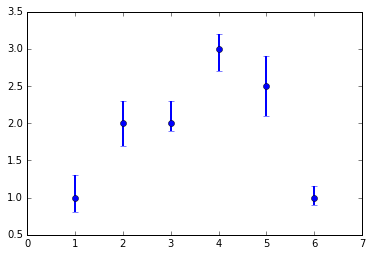

plotted catalog!
1.88907180265e-05
3.54683982441e-116
7.36743261938e-281


/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


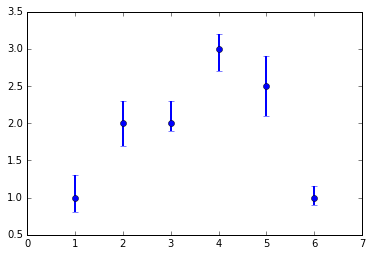

plotted catalog!
1.0084624764e-06
5.98760102277e-113
1.24373383832e-277


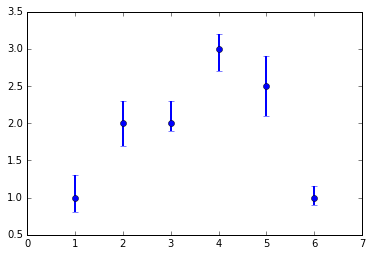

plotted catalog!
1.131501237e-10
1.44737636663e-115
3.00646445397e-280


In [17]:
#run the montecarlo for different coreelation sigmas
distribution_1=montecarlo(x_knots, sigma[0])
distribution_2=montecarlo(x_knots, sigma[1])
distribution_3=montecarlo(x_knots, sigma[2])

ValueError: Contour levels must be increasing

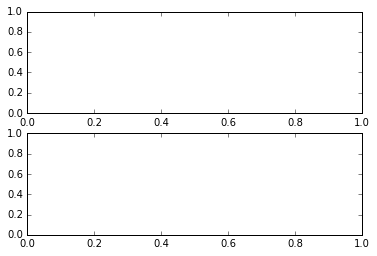

In [18]:
#effect of different correlation sigmas
fig,axarr=plt.subplots(2,1)

auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_1[:,0], distribution_1[:,1], [[1., 4.], [1., 4.]], [100, 100], True)
axarr[0].contourf(auxplot1, auxplot2, auxplot3, auxplot4, cmap=cm.get_cmap(cm.Reds, 2000), hold='on', alpha=.2)
auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_2[:,0], distribution_2[:,1], [[1., 4.], [1., 4.]], [100, 100], True)
cset2= axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[:2], linewidths=4, linestyles='--', colors='darkblue', hold='on', alpha=1)
axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[2:4], linewidths=4, linestyles='--', colors='blue', hold='on', alpha=.8)
axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[-2:], linewidths=4, linestyles='--', colors='blue', hold='on', alpha=.6)
auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_3[:,0], distribution_3[:,1], [[1., 4.], [1., 4.]], [100, 100], True)
cset3= axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[:2], linewidths=1, linestyles='-', colors='black', hold='on', alpha=1)
axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[2:4], linewidths=1, linestyles='-', colors='black', hold='on', alpha=.8)
axarr[0].contour(auxplot1, auxplot2, auxplot3, auxplot4[-2:], linewidths=1, linestyles='-', colors='black', hold='on', alpha=.6)

auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_1[:,0], distribution_1[:,2], [[1., 4.], [1., 4.]], [100, 100], True)
axarr[1].contourf(auxplot1, auxplot2, auxplot3, auxplot4, cmap=cm.get_cmap(cm.Reds, 2000), hold='on', alpha=.2)
auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_2[:,0], distribution_2[:,2], [[1., 4.], [1., 4.]], [100, 100], True)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[:2], linewidths=4, linestyles='--', colors='darkblue', hold='on', alpha=1)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[2:4], linewidths=4, linestyles='--', colors='blue', hold='on', alpha=.8)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[-2:], linewidths=4, linestyles='--', colors='blue', hold='on', alpha=.6)
auxplot1, auxplot2, auxplot3, auxplot4= plotting(distribution_3[:,0], distribution_3[:,2], [[1., 4.], [1., 4.]], [100, 100], True)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[:2], linewidths=1, linestyles='-', colors='black', hold='on', alpha=1)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[2:4], linewidths=1, linestyles='-', colors='black', hold='on', alpha=.8)
axarr[1].contour(auxplot1, auxplot2, auxplot3, auxplot4[-2:], linewidths=1, linestyles='-', colors='black', hold='on', alpha=.6)

lines=[cset2.collections[0], cset3.collections[0]]
labels=['Sigma= '+str(sigma[1]), 'Sigma= '+str(sigma[2])]
axarr[0].legend(lines, labels)
axarr[1].legend(lines, labels)
axarr[0].set_xlabel('Knot 1 (z=2)')
axarr[0].set_ylabel('Knot 2 (z=3.5)')
axarr[1].set_xlabel('Knot 1 (z=2)')
axarr[1].set_ylabel('Knot 3 (z=5)')
plt.savefig('sigmas.png')
plt.show()

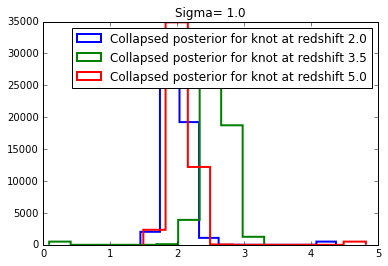

In [13]:
fig=plt.figure()
for i in range(3):
    plt.hist(distribution_2[:,i], histtype='step', linewidth=2, label='Collapsed posterior for knot at redshift ' +str(x_knots[i]))
plt.legend()
plt.title('Sigma= '+str(sigma[1]))
plt.savefig('histogram.png')
plt.show()